In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import collections
import re
import pandas as pd
import numpy as np
import unicodedata
import glob
import pickle

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers
from keras import optimizers

Using TensorFlow backend.


In [2]:
# DEFAULT_DATA_PATH = 'C:/Users/org81/Downloads/parsed/parsed/'
# DEFAULT_DATA_PATH = 'C:/Users/Rocku/Downloads/parsed/parsed/'
DEFAULT_DATA_PATH = 'C:/Users/FinPC/Downloads/parsed/parsed/'

# index_file = pd.read_csv(DEFAULT_DATA_PATH + 'masterIndex.csv')
index_file = pd.read_csv('sicmerged.csv')

index_file.head(10)

,COMPANY_NAME,FORM_TYPE,DATE_FILED,QUARTER,EXCHANGE,fyear,gvkey,datadate,indfmt,consol,...,exchg,cik,costat,naicsh,sich,mkvalt,gind,gsector,gsubind,naics
0,SANDISK CORP,10-K,2013-02-19,1,NASDAQ,2012,61513.0,20121231.0,INDL,C,...,14.0,1000180.0,I,334112.0,3572.0,10502.2920,452020.0,45.0,45202030.0,334112.0
1,MEDALLION FINANCIAL CORP,10-K,2013-03-13,1,NASDAQ,2012,62919.0,20121231.0,FS,C,...,14.0,1000209.0,A,523910.0,6797.0,NaN,402030.0,40.0,40203010.0,523910.0
2,HENRY SCHEIN INC,10-K,2013-02-13,1,NASDAQ,2012,61494.0,20121231.0,INDL,C,...,14.0,1000228.0,A,423450.0,5047.0,7064.9774,351020.0,35.0,35102010.0,423450.0
3,CORE LABORATORIES N V,10-K,2013-02-19,1,NYSE,2012,61759.0,20121231.0,INDL,C,...,11.0,1000229.0,A,213112.0,1389.0,5066.4092,101010.0,10.0,10101020.0,213112.0
4,KENTUCKY BANCSHARES INC KY,10-K,2013-03-28,1,OTC,2012,63165.0,20121231.0,FS,C,...,19.0,1000232.0,A,522110.0,6020.0,50.3200,401010.0,40.0,40101015.0,522110.0
5,IMPAC MORTGAGE HOLDINGS INC,10-K,2013-03-12,1,NYSE MKT,2012,61586.0,20121231.0,FS,C,...,12.0,1000298.0,A,522292.0,6162.0,119.4834,401020.0,40.0,40102010.0,522292.0
6,SCHWEITZER MAUDUIT INTERNATIONAL INC,10-K,2013-03-01,1,NYSE,2012,61519.0,20121231.0,INDL,C,...,11.0,1000623.0,A,322121.0,2621.0,1217.7750,151050.0,15.0,15105020.0,322121.0
7,NOVAVAX INC,10-K,2013-03-12,1,NASDAQ,2012,61655.0,20121231.0,INDL,C,...,14.0,1000694.0,A,325414.0,2836.0,279.6123,352010.0,35.0,35201010.0,325414.0
8,WATERS CORP DE,10-K,2013-02-26,1,NYSE,2012,61574.0,20121231.0,INDL,C,...,11.0,1000697.0,A,334516.0,3826.0,7526.2968,352030.0,35.0,35203010.0,334516.0
9,INSPERITY INC,10-K,2013-02-11,1,NYSE,2012,64302.0,20121231.0,INDL,C,...,11.0,1000753.0,A,561320.0,7363.0,835.5547,202020.0,20.0,20202010.0,561320.0


In [3]:
# index_file = index_file[index_file['YEAR'] == 2013]

In [4]:
txt_files = glob.glob(DEFAULT_DATA_PATH +'*.txt')
len(txt_files)

def filesort(filename):
    file_raw_name = filename.split('\\')[-1].split('.')[0]
    return int(file_raw_name)

txt_files = sorted(txt_files,key=filesort, reverse=False)
len(txt_files)

22631

In [6]:
def process_text(text):
    """
        Preprocess Text
    """
    text = unicodedata.normalize("NFKD", text) # Normalize
    text = '\n'.join(text.splitlines()) # Let python take care of unicode break lines

    # Convert to upper
    text = text.upper() # Convert to upper
    
    # remove tag and scripts
    text = re.sub(r"<.*?>", "", text)
    

    # Take care of breaklines & whitespaces combinations due to beautifulsoup parsing
    text = re.sub(r'[ ]+\n', '\n', text)
    text = re.sub(r'\n[ ]+', '\n', text)
    text = re.sub(r'\n+', '\n', text)

    # To find MDA section, reformat item headers
    text = text.replace('\n.\n','.\n') # Move Period to beginning

    text = text.replace('\nI\nTEM','\nITEM')
    text = text.replace('\nITEM\n','\nITEM ')
    text = text.replace('\nITEM  ','\nITEM ')

    text = text.replace(':\n','.\n')

    # Math symbols for clearer looks
    text = text.replace('$\n','$')
    text = text.replace('\n%','%')

    # Reformat
    text = text.replace('\n','\n\n') # Reformat by additional breakline
    # remove 특수기호
    text = re.sub(r"[\{\}\[\]\/;:|\)*~`!^\-_+<>@\#$%&\\\=\(\\]", "", text)

    return text


business_part = []
company = []
sic= []
naics = []
# snms = []
fyear = []
gvkey = []
cik = []
ex = []
cusip = []
gind = []
gsector = []

for ind, txt_file in enumerate(txt_files):
    if (ind%100 == 0):
        print(ind, end=' // ')
    dummy = ''
    company_name = index_file.loc[ind,'conm']
    sic_code = index_file.loc[ind,'sich']
    gvkey_indi = index_file.loc[ind,'gvkey']
    exchange_indi = index_file.loc[ind,'EXCHANGE']
    naics_code = index_file.loc[ind,'naicsh']
#     snms_text = index_file.loc[ind,'snms']
    fyear_code = index_file.loc[ind,'fyear']
    cik_indi = index_file.loc[ind,'cik']
    cusip_indi = index_file.loc[ind,'cusip']
    gind_indi = index_file.loc[ind,'gind']
    gsector_indi = index_file.loc[ind,'gsector']
        
    if exchange_indi == 'OTC':
        continue
    
    with open(txt_file, "r", encoding='utf-8') as f:
        dummy = f.read()
        dummy = process_text(dummy)
        
    splitted = dummy.lower().split('°item')
    for chunk in splitted:
        if (chunk.lower().strip().startswith('1. business') and len(chunk) > 1000):
            business_part.append(chunk)
            company.append(company_name)
            sic.append(sic_code)
            naics.append(naics_code)
#             snms.append(snms_text)
            fyear.append(fyear_code)
            ex.append(exchange_indi)
            gvkey.append(gvkey_indi)
            cusip.append(cusip_indi)
            cik.append(cik_indi)
            gind.append(gind_indi)
            gsector.append(gsector_indi)
        continue

In [10]:
comp_sic_data = {
    'business_part':business_part,
    'company': company,
    'sic':sic,
    'naics':naics,
#     'snms':snms,
    'fyear':fyear,
    'exchange':ex,
    'gvkey': gvkey,
    'cik': cik,
    'ex': ex,
    'cusip': cusip,
    'gind': gind,
    'gsector': gsector
}

with open('comp_sic_merged_0510.pickle', 'wb') as f:
    pickle.dump(comp_sic_data, f)

In [168]:
comp_sic_df = pd.DataFrame(comp_sic_data)
comp_sic_df.head()

,business_part,company,exchange,fyear,gvkey,naics,sic,snms
0,1. business this annual report on form 10k co...,SANDISK CORP,NASDAQ,2013.0,61513.0,334112.0,3572.0,Flash Memory Storage
1,1. business general we believe we are the wor...,SCHEIN (HENRY) INC,NASDAQ,2013.0,61494.0,423450.0,5047.0,Healthcare Distribution
2,1. business general core laboratories n.v. is...,CORE LABORATORIES NV,NYSE,2013.0,61759.0,213112.0,1389.0,Reservoir Management
3,"1. business impac mortgage holdings, inc., so...",IMPAC MORTGAGE HOLDINGS INC,NYSE MKT,2013.0,61586.0,522292.0,6162.0,Long-term Portfolio
4,1. business general schweitzermauduit interna...,SCHWEITZER-MAUDUIT INTL INC,NYSE,2013.0,61519.0,322121.0,2621.0,Engineered Papers


In [169]:
# comp_sic_remove_finance = comp_sic_df[(comp_sic_df['sic'] < 6000 ) | (comp_sic_df['sic'] >= 7000)]
# comp_sic_remove_finance.shape

In [13]:
lemma = nltk.wordnet.WordNetLemmatizer()
is_noun = lambda pos: pos[:2] == 'NN'
st = PorterStemmer()

i=0
# # word_data = []
def tokenize(text):
    global i
    if (i%100 == 0):
        print(i, end=' // ')
    
    tokens = nltk.word_tokenize(text.lower())
    token_after = [w for w in tokens if (w.isalpha() and len(w) > 2)]
#     token_after_geo = [w for w in token_after if (not w in stopwords.words('english'))]
    stems = [lemma.lemmatize(word) for (word, pos) in nltk.pos_tag(token_after) if is_noun(pos)]
    i += 1
    
    del tokens, token_after
    return stems

count_vect = CountVectorizer(max_df = 0.20, max_features=2000, tokenizer=tokenize, stop_words='english', lowercase=True, analyzer='word')
# count_vect = TfidfVectorizer(max_df = 0.2, max_features=2000, tokenizer=tokenize, stop_words='english', lowercase=True, analyzer='word')

X_train_counts = count_vect.fit_transform(comp_sic_data['business_part'])

In [14]:
print(X_train_counts.shape)

(18072, 2000)


In [350]:
# comp_name_indi = 'CHEVRON CORP'
# inds = company.index(comp_name_indi)
# words_comp =pd.Series(count_vect.inverse_transform(X_train_counts.toarray()[inds])[0])
# words_comp.to_csv('sample firm/'+comp_name_indi+'.csv')

In [15]:
rawtrain_counts = pd.DataFrame(X_train_counts.toarray())
sum_of_words = rawtrain_counts.sum(axis=1)
med_of_words = sum_of_words.median(axis=0)
mean_of_words = sum_of_words.mean(axis=0)
print(med_of_words, ':', mean_of_words)
sum_of_words.hist(bins=int(round((sum_of_words.max(axis=0))/10,0)))
sum_of_words.to_csv('sum_of_words.csv')

348.0 : 457.94931385568833


In [16]:
# Save Trainied data
with open('X_train_counts_2000_0510.pickle', 'wb') as f:
    pickle.dump(X_train_counts, f)

In [5]:
# Load previous Trainied data
# with open('D:/10k_data/X_train_counts_10000_full_merged_0410.pickle', 'rb') as f:
with open('X_train_counts_2000_0510.pickle', 'rb') as f:
    X_train_counts = pickle.load(f)

In [8]:
X_train_counts.toarray()

<18072x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 2639620 stored elements in Compressed Sparse Row format>

In [7]:
# Load 
with open('comp_sic_merged_0510.pickle', 'rb') as f:
    comp_sic_data = pickle.load(f)

business_part = comp_sic_data['business_part']
company = comp_sic_data['company']
sic = comp_sic_data['sic']
naics = comp_sic_data['naics']
# snms = comp_sic_data['snms']
fyear = comp_sic_data['fyear']
exchange = comp_sic_data['exchange']
gvkey = comp_sic_data['gvkey']
cik = comp_sic_data['cik']
ex = comp_sic_data['ex']
cusip = comp_sic_data['cusip']
gind = comp_sic_data['gind']
gsector = comp_sic_data['gsector']

In [34]:
X_2012 = X_train_counts.toarray()[pd.Series(fyear) == 2012]
X_2012.shape

(3827, 2000)

In [5]:
# sorted(dict(count_vect.vocabulary_).items(), key=lambda x: x[1])

# Autoencoder - Training

In [41]:
input_length = 2000

input_words = Input(shape=(input_length,))
encoded = Dense(500, activation='relu')(input_words)
encoded = Dense(125, activation='relu')(encoded)
encoded = Dense(2, activation='linear')(encoded) # Hidden output node (Reduced output)
decoded = Dense(125, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(input_length, activation='sigmoid')(decoded)

autoencoder = Model(input_words, decoded)
encoder=Model(input_words, encoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# autoencoder.compile(optimizer='Adadelta', loss='binary_crossentropy')
# autoencoder.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# total_samples = X_train_counts.shape[0]
total_samples = X_2012.shape[0]

train_samples = int(round(7*total_samples/10,0))
x = X_2012
x_train = x[:train_samples]
x_test = x[train_samples+1:]

autoencoder.fit(x_train, x_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test,x_test))

Train on 2679 samples, validate on 1147 samples
Epoch 1/300
2679/2679 [==============================] - 2s 746us/step - loss: 0.4907 - acc: 0.6935 - val_loss: 0.2415 - val_acc: 0.7595
Epoch 2/300
2679/2679 [==============================] - 1s 478us/step - loss: -0.0474 - acc: 0.7391 - val_loss: 0.0334 - val_acc: 0.7751
Epoch 3/300
2679/2679 [==============================] - 1s 475us/step - loss: -0.2725 - acc: 0.7706 - val_loss: -0.0665 - val_acc: 0.7714
Epoch 4/300
2679/2679 [==============================] - 1s 469us/step - loss: -0.3966 - acc: 0.7768 - val_loss: -0.1312 - val_acc: 0.7846
Epoch 5/300
2679/2679 [==============================] - 1s 460us/step - loss: -0.4862 - acc: 0.7860 - val_loss: -0.1881 - val_acc: 0.7885
Epoch 6/300
2679/2679 [==============================] - 1s 464us/step - loss: -0.5602 - acc: 0.7939 - val_loss: -0.2292 - val_acc: 0.8066
Epoch 7/300
2679/2679 [==============================] - 1s 476us/step - loss: -0.6138 - acc: 0.8058 - val_loss: -0.2526 

2679/2679 [==============================] - 1s 472us/step - loss: -1.3255 - acc: 0.8751 - val_loss: -0.5953 - val_acc: 0.8846
Epoch 118/300
2679/2679 [==============================] - 1s 468us/step - loss: -1.3260 - acc: 0.8758 - val_loss: -0.5933 - val_acc: 0.8848
Epoch 119/300
2679/2679 [==============================] - 1s 497us/step - loss: -1.3258 - acc: 0.8750 - val_loss: -0.5902 - val_acc: 0.8863
Epoch 120/300
2679/2679 [==============================] - 1s 516us/step - loss: -1.3242 - acc: 0.8753 - val_loss: -0.5884 - val_acc: 0.8843
Epoch 121/300
2679/2679 [==============================] - 1s 503us/step - loss: -1.3259 - acc: 0.8751 - val_loss: -0.5880 - val_acc: 0.8847
Epoch 122/300
2679/2679 [==============================] - 1s 480us/step - loss: -1.3299 - acc: 0.8758 - val_loss: -0.5894 - val_acc: 0.8840
Epoch 123/300
2679/2679 [==============================] - 1s 476us/step - loss: -1.3353 - acc: 0.8752 - val_loss: -0.5899 - val_acc: 0.8856
Epoch 124/300
2679/2679 [==

2679/2679 [==============================] - 1s 460us/step - loss: -1.4753 - acc: 0.8804 - val_loss: -0.5138 - val_acc: 0.8815
Epoch 234/300
2679/2679 [==============================] - 1s 457us/step - loss: -1.4762 - acc: 0.8803 - val_loss: -0.5108 - val_acc: 0.8839
Epoch 235/300
2679/2679 [==============================] - 1s 462us/step - loss: -1.4796 - acc: 0.8805 - val_loss: -0.5070 - val_acc: 0.8821
Epoch 236/300
2679/2679 [==============================] - 1s 462us/step - loss: -1.4809 - acc: 0.8806 - val_loss: -0.5059 - val_acc: 0.8835
Epoch 237/300
2679/2679 [==============================] - 1s 494us/step - loss: -1.4835 - acc: 0.8814 - val_loss: -0.5059 - val_acc: 0.8817
Epoch 238/300
2679/2679 [==============================] - 1s 472us/step - loss: -1.4835 - acc: 0.8803 - val_loss: -0.5027 - val_acc: 0.8828
Epoch 239/300
2679/2679 [==============================] - 1s 468us/step - loss: -1.4834 - acc: 0.8803 - val_loss: -0.5045 - val_acc: 0.8831
Epoch 240/300
2679/2679 [==

In [42]:
encoded_words = encoder.predict(X_train_counts.toarray())
data_result = pd.DataFrame(encoded_words)
data_result['company'] = company
data_result['sic'] = sic
# data_result['snms'] = snms
data_result['naics'] = naics
data_result['fyear'] = fyear
data_result['gvkey'] = gvkey
data_result['exchange'] = exchange
data_result['ex'] = ex
data_result['cik'] = cik
data_result['cusip'] = cusip
data_result['gind'] = gind
data_result['gind'] = gind
data_result['gsector'] = gsector

# data_end = data_result.dropna()
data_end = data_result
data_end.count()

0           18072
1           18072
company     18072
sic         16398
naics       16329
fyear       18072
gvkey       16335
exchange    16437
ex          16437
cik         18072
cusip       16335
gind        16312
gsector     16312
dtype: int64

# Export

In [43]:
data_end.to_excel('2d_FinalResult_0724(trainonly2012).xlsx')

# Visualization

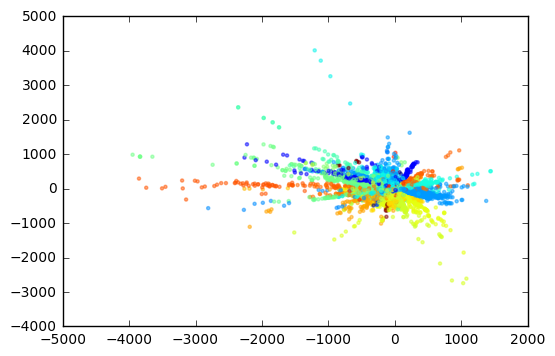

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt

xs, ys = data_end[0], data_end[1]
# xs, ys, zs = data_result[0]*10, data_result[1]*10, data_result[2]*10
# c = data_end['ff12']
plt.scatter(xs,ys, c=c, marker='o',edgecolors='face',s=5, alpha=0.5)

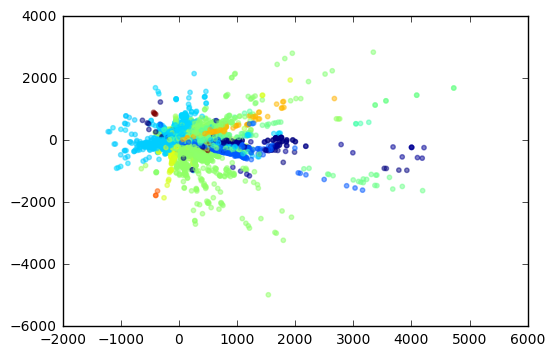

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

xs, ys = data_end[0], data_end[1]
# xs, ys, zs = data_result[0]*10, data_result[1]*10, data_result[2]*10
c = data_end['naics']
plt.scatter(xs,ys, c=c, marker='o',edgecolors='face',s=10, alpha=0.5)

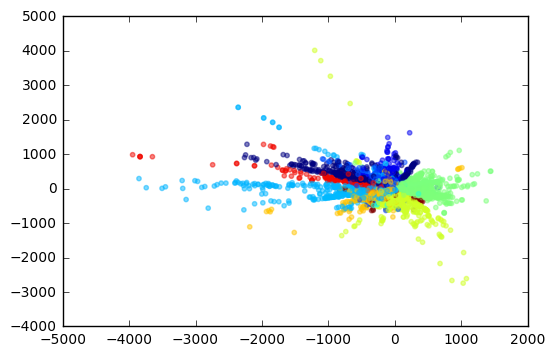

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

xs, ys = data_end[0], data_end[1]
# xs, ys, zs = data_result[0]*10, data_result[1]*10, data_result[2]*10
c = data_end['gind']
plt.scatter(xs,ys, c=c, marker='o',edgecolors='face',s=10, alpha=0.5)

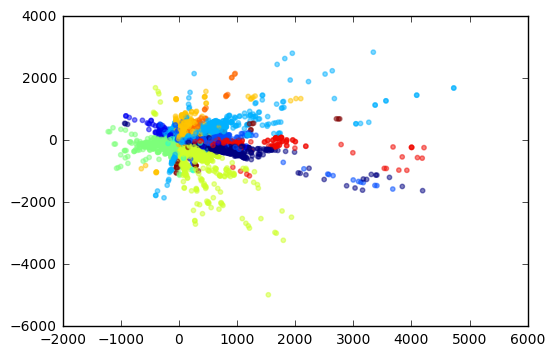

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

xs, ys = data_end[0], data_end[1]
# xs, ys, zs = data_result[0]*10, data_result[1]*10, data_result[2]*10
c = data_end['gsector']
plt.scatter(xs,ys, c=c, marker='o',edgecolors='face',s=10, alpha=0.5)

# Convert SIC to FF12

In [140]:
def ff12_class(sic):
    industry_code = 10
    if ((100 <= sic <= 999) or (2000 <= sic <= 2399) or (2700 <= sic <= 2749) or (2770 <= sic <= 2799) or (3100 <= sic <= 3199) or (3940 <= sic <= 3989)):
        industry_code =  1 # Consumer Non Durable
    elif ((2500 <= sic <= 2519) or (2590 <= sic <= 2599) or (3630 <= sic <= 3659) or (3710 <= sic <= 3711) or 
          (3714 <= sic <= 3714) or (3716 <= sic <= 3716) or (3750 <= sic <= 3751) or (3792 <= sic <= 3792) or (3900 <= sic <= 3939) or (3990 <= sic <= 3999)):
        industry_code =  2 # Consumer Durable
    elif ((2520 <= sic <= 2589) or (2600 <= sic <= 2699) or (2750 <= sic <= 2769) or (3000 <= sic <= 3099) or 
          (3200 <= sic <= 3569) or (3580 <= sic <= 3621) or (3700 <= sic <= 3709) or (3712 <= sic <= 3713) or (3715 <= sic <= 3715) or 
          (3717 <= sic <= 3749) or (3752 <= sic <= 3791) or (3793 <= sic <= 3799) or (3830 <= sic <= 3839) or (3860 <= sic <= 3899)):
        industry_code = 3 # Manufacturing
    elif ((1200 <= sic <= 1399) or (2900 <= sic <= 2999)):
        industry_code = 4 # Energy
    elif ((2800 <= sic <= 2829) or (2840 <= sic <= 2899)):
        industry_code = 5 # Chemicals
    elif ((3570 <= sic <= 3579) or (3660 <= sic <= 3692) or (3694 <= sic <= 3699) or (3810 <= sic <= 3829) or (7370 <= sic <= 7379)):
        industry_code = 6 # Business equipment
    elif (4800 <= sic <= 4899):
        industry_code = 7 # Telecom
    elif (4900 <= sic <= 4949):
        industry_code = 8 # Utilities
    elif ((5000 <= sic <= 5999) or (7200 <= sic <= 7299) or (7600 <= sic <= 7699)):
        industry_code = 9 # Shops Wholesale (Retail)
    elif ((2830 <= sic <= 2839) or (3693 <= sic <= 3693) or (3840 <= sic <= 3859) or (8000 <= sic <= 8099)):
        industry_code = 10 # Healthcare, medical, drugs
    elif (6000 <= sic <= 6999):
        industry_code = 11 # Money Finance
    else:
        industry_code = 12 # Others
        
    return industry_code

In [141]:
data_end['ff12'] = data_end['SIC'].apply(lambda sic: ff12_class(sic))

c:\program files\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Convert SIC to FF49

In [142]:
ff49_index= pd.read_csv('Siccodes49.csv')
ff49_index.head()

,ff49,sic1,sic2
0,1,100,199
1,1,200,299
2,1,700,799
3,1,910,919
4,1,2048,2048


In [143]:
def ff49_class(sic):
    target_data = ff49_index[(ff49_index['sic1'] <= sic) & (ff49_index['sic2'] >= sic)]
    if len(target_data) == 0:
        ff_code = 49
    else:
        ff_code = target_data['ff49'].values[0]
    return ff_code

In [144]:
data_end['ff49'] = data_end['SIC'].apply(lambda sic: ff49_class(sic))

c:\program files\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Find the best clusters

In [137]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data_range = range(0,2)
# data_range = range(0,10)
pre_data = data_end.loc[:,data_range]

# precision = []
# for clusters in range(2,50):
#     kmeans = KMeans(n_clusters=clusters).fit(pre_data)
#     kmeans.transform(pre_data)
#     precision.append(kmeans.inertia_)

#     silhouette_avg = silhouette_score(pre_data, kmeans.labels_)
#     print("For n_clusters =", clusters, "The average silhouette_score is :", silhouette_avg)
    
# plt.plot(precision)
# kmeans = KMeans(n_clusters=3).fit(pre_data)
# kmeans_result = kmeans.fit_predict(pre_data)

In [138]:
kmeans = KMeans(n_clusters=12).fit(pre_data)
# kmeans_result = kmeans.predict(pre_data)

In [139]:
data_end['clustered'] = kmeans.labels_
data_end.head(5)

c:\program files\anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,0,1,Company,SIC,snms,naics,fyear,gvkey,exchange,clustered
0,-117.717987,-119.254684,SANDISK CORP,3572.0,Flash Memory Storage,334112.0,2013.0,61513.0,NASDAQ,6
1,-6.685239,-104.207031,SCHEIN (HENRY) INC,5047.0,Healthcare Distribution,423450.0,2013.0,61494.0,NASDAQ,1
2,42.010952,54.473701,CORE LABORATORIES NV,1389.0,Reservoir Management,213112.0,2013.0,61759.0,NYSE,2
5,-65.591118,-28.037888,SCHWEITZER-MAUDUIT INTL INC,2621.0,Engineered Papers,322121.0,2013.0,61519.0,NYSE,2
6,-38.663685,-4.287819,NOVAVAX INC,2836.0,Recombinant Vaccines,325414.0,2013.0,61655.0,NASDAQ,2


In [145]:
# data_indi = data_end[data_end['clustered'] == 0]
cross_tab = pd.crosstab(data_end["ff12"],data_end['clustered'],margins=True)

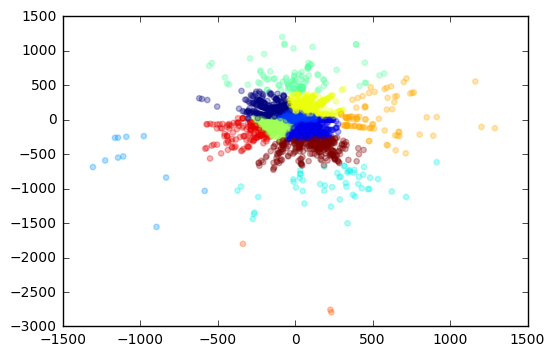

In [147]:
xs, ys = data_end[0], data_end[1]
# xs, ys, zs = data_result[0]*10, data_result[1]*10, data_result[2]*10
c = data_end['clustered']
plt.scatter(xs,ys, c=c, marker='o',edgecolors='face',s=15, alpha=0.3)

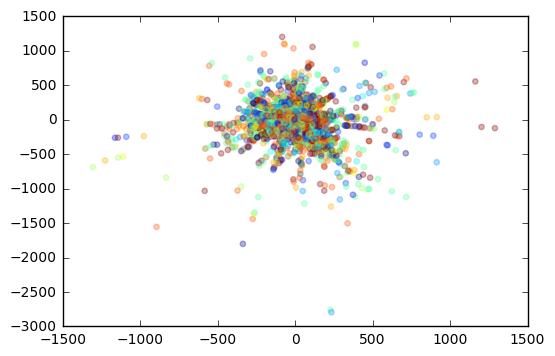

In [151]:
xs, ys = data_end[0], data_end[1]
plt.scatter(xs,ys, c=data_end['ff12'],  marker='o',edgecolors='face',s=15, alpha=0.3)

# Polar to Cartesian

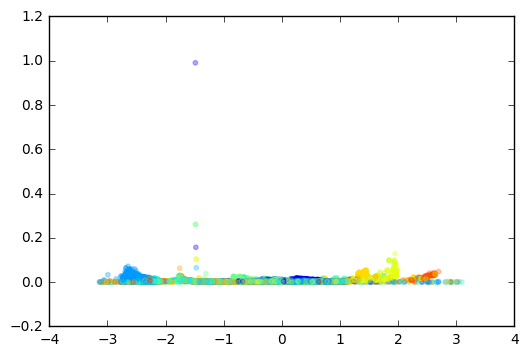

In [32]:
range_ = range(0,2)
pre_data = data_end.loc[:,range_]
pre_data_norm = (pre_data - pre_data.mean())/pre_data.var()
pre_data_norm['size'] = np.sqrt(pre_data_norm[0]**2 + pre_data_norm[1]**2)
pre_data_norm['angle'] = np.arccos(pre_data_norm[0]/pre_data_norm['size'])
pre_data_norm['angle'] = np.where(pre_data_norm[1]>=0, pre_data_norm['angle'], -1*pre_data_norm['angle'])
c = data_end['SIC']
plt.scatter(pre_data_norm['angle'], pre_data_norm['size'], c=c,marker='o',edgecolors='face',s=10, alpha=0.3)

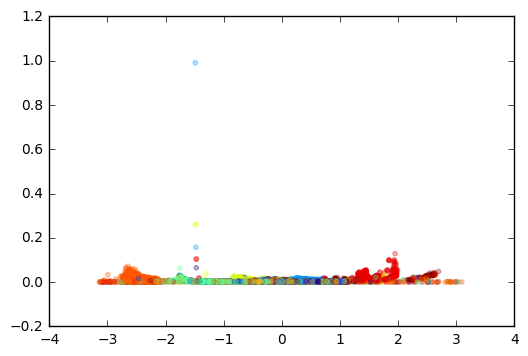

In [33]:
c = data_end['ff12']
plt.scatter(pre_data_norm['angle'], pre_data_norm['size'], c=c,marker='o',edgecolors='face',s=10, alpha=0.3)

In [34]:
transformed_data = pre_data_norm.loc[:,['angle','size']]
kmeans = KMeans(n_clusters=18)
data_end['clustered'] = kmeans.fit_predict(transformed_data)

c:\program files\anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(-500, 700)

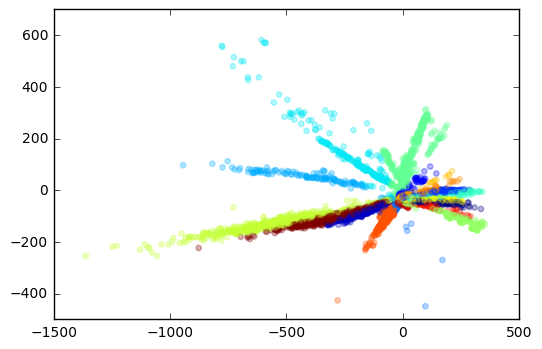

In [36]:
xs, ys = data_end[0], data_end[1]
# xs, ys, zs = data_result[0]*10, data_result[1]*10, data_result[2]*10
c = data_end['clustered']
plt.scatter(xs, ys, c=c, marker='o',edgecolors='face',s=15, alpha=0.3)
plt.xlim(-1500,500)
plt.ylim(-500,700)

In [144]:
cross_tab = pd.crosstab(data_end["ff49"],data_end['clustered'],margins=True)
cross_tab

clustered,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,All
ff49,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,4,0,1,0,0,5,0,...,11,0,0,0,0,0,0,0,5,44
2,0,1,0,60,0,0,0,0,7,0,...,13,0,0,0,0,0,1,0,60,168
3,0,0,0,38,0,0,0,0,0,0,...,7,0,0,0,0,0,0,0,47,97
4,0,0,0,44,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,29,75
5,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,15
6,0,8,0,36,0,0,3,0,0,4,...,1,0,0,0,0,0,0,13,21,92
7,0,0,0,29,0,0,29,0,0,0,...,0,0,0,0,0,0,0,4,60,163
8,0,0,0,6,0,0,10,0,0,29,...,0,0,0,0,4,0,0,0,5,54
9,1,0,0,69,0,0,7,0,8,2,...,11,0,0,0,0,0,0,3,62,173
